In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm

### Hermite Solver of Biharmonic Equation $(E(x)u^{\prime \prime})^{\prime \prime} = \mathcal{f(x)}$

This is the Jupyter notebook that contains the relevant code for the Special Topic. In this notebook, we aim to solve the biharmonic equation $$(E(x)u^{\prime \prime})^{\prime \prime} = \mathcal{f(x)} \tag{1}$$ where $x \in \Omega = [a, b]$, and the Boundary Conditions are $$u(a) = b_1 , u^{\prime}(a) = b_2, u(b) = b_3, u^{\prime}(b) = b_4$$

Assumptions:
*   $E(x)$ is a (discontinous) constant function or continuous function such that $E(x) \in L^2(\Omega)$
*   $E(x)$ is positive over $\Omega = [a, b]$, i.e., $E(x) > 0 \ \forall x \in \Omega$
*   $b_{i, i = 1, 2, 3, 4}$ are constants
*   $b > a$
*   $\mathcal{f}(x) \in L^2(\Omega)$

### Weak Form of (1)
Find $$u\in S = \{u| u\in H^2(\Omega), (a) = b_1 , u^{\prime}(a) = b_2, u(b) = b_3, u^{\prime}(b) = b_4\rbrace$$ such that $$a(u,v) = \int^b_a v^{\prime \prime}(x) E(x) u^{\prime \prime}(x) dx = F(v) = \int^b_a \mathcal{f}(x) v(x)  dx$$ for any test functions $v \in T = H^2_0(\Omega)$

### Reference Element
Define to be $\bar{\Omega} = [0, 1]$ and hence the reference nodal basis **cubic Hermite** functions:$$N_1(x) = 2x^3 - 3x^2 + 1$$,$$N_2(x) = x^3 - 2x^2 + x$$,$$N_3(x) = -2x^3 + 3x^2$$, $$N_4(x) = x^3 - x^2$$ for $x \in \bar{\Omega}$

In [2]:
# Hermite Functions
N1 = lambda x: 2 * x**3 - 3 * x**2 + 1
N2 = lambda x: x**3 - 2 * x**2 + x
N3 = lambda x: -2 * x**3 + 3 * x**2
N4 = lambda x: x**3 - x**2

# corresponding 1st order derivatives
N1_x = lambda x: 6 * x**2 - 6 * x
N2_x = lambda x: 3 * x**2 - 4 * x + 1
N3_x = lambda x: -6 * x**2 + 6 * x
N4_x = lambda x: 3 * x**2 - 2 * x

# corresponding 2nd order derivatives
N1_xx = lambda x: 12 * x - 6
N2_xx = lambda x: 6 * x - 4
N3_xx = lambda x: -12 * x + 6
N4_xx = lambda x: 6 * x - 2

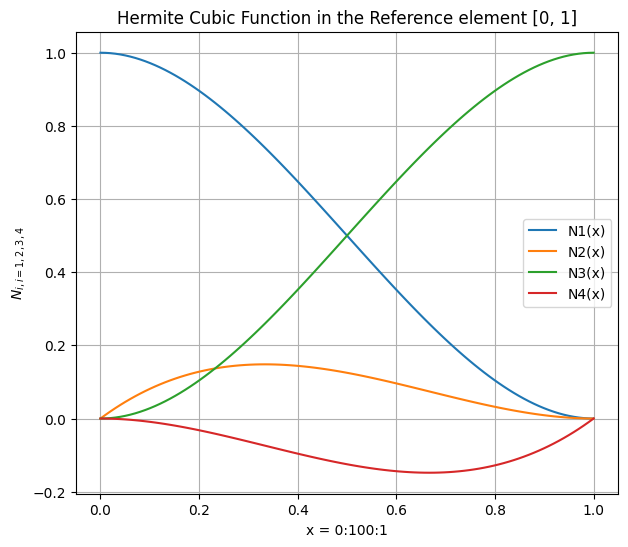

In [3]:
# visualization
N_vis = [N1, N2, N3, N4]
ref_dom = np.linspace(0, 1, 100)
plt.figure(figsize=(7, 6))
for i_ in range(4):
    plt.plot(ref_dom, N_vis[i_](ref_dom), label=f"N{i_+1}(x)")
plt.xlabel("x = 0:100:1")
plt.ylabel(r"$N_{i, i = 1, 2, 3, 4}$")
plt.title("Hermite Cubic Function in the Reference element [0, 1]")
plt.legend(loc="best")
plt.grid()

### Nodal Basis Functions in an arbitrary interval $[x_l, x_r]$

Consider the mapping $\xi(x)$ from $[x_l, x_r]$ to $[0, 1]$: $$\xi(x) = \frac{x - x_l}{x_r - x_l}$$ 
Hence, the nodal basis funcions become: $$\psi_1(x) = N_1(\xi(x))$$,$$\psi_2(x) = \mathcal{h} N_2(\xi(x))$$, $$\psi_3(x) = N_3(\xi(x))$$,$$\psi_4 = \mathcal{h} N_4(\xi(x))$$ where $\mathcal{h} = x_r - x_l$

In [4]:
# ref map
def xi(x, x_l, x_r):
    """
    Mapping back to the Reference element

    arbitrary interval = [x_l, x_r]
    """
    return (x - x_l) / (x_r - x_l)


# nodal basis function in an arbitrary interval
def psi_1(x, xl, xr):
    return N1(xi(x, xl, xr))


def psi_2(x, xl, xr):
    return (xr - xl) * N2(xi(x, xl, xr))


def psi_3(x, xl, xr):
    return N3(xi(x, xl, xr))


def psi_4(x, xl, xr):
    return (xr - xl) * N4(xi(x, xl, xr))

### Global Basis Function $\{\phi_i \rbrace_{i = 1}^{2n}$
Consider a (uniform) partition of $\bar{\Omega} = [a, b]$ defined by $\Gamma_h = \bigcup_{k=1}^{n-1} e_k$ where $e_k = [x_k, x_{k+1}]$ such that $$a = x_1 < x_2 < \cdots < x_i = \alpha < \cdots < x_{n-1} < x_{n} = b$$, where $x_i = \alpha$ is the node where $E(x)$ could be discontinous.

Let $\psi_{k,i}: [x_k,x_{k+1}] \mapsto R, i = 1, 2, 3, 4$ denote the Hermite cubic nodal basis functions defined over the cell/element/sub-interval $e_k = [x_k ,x_{k+1}]$

At $x_1$,         $e_1 = [x_1, x_2]$, define:
$$
\begin{equation}
    \phi_1 (x) = 
    \begin{cases}
        0, & \text{if}\ x\notin [x_1, x_2] \\
        \psi_{1,1}, & \text{if}\ x\in [x_1, x_2]
    \end{cases}
\end{equation}
$$
$$
\begin{equation}
    \phi_2 (x) = 
    \begin{cases}
        0, & \text{if}\ x\notin [x_1, x_2] \\
        \psi_{1,2}, & \text{if}\ x\in [x_1, x_2]
    \end{cases}
\end{equation}
$$

At $x_{k}$:
$$
\begin{equation}
    \phi_{2k-1} (x) = 
    \begin{cases}
        0, & \text{if}\ x\notin [x_{k-1}, x_{k+1}] \\
        \psi_{k-1,3}, & \text{if}\ x\in [x_{k-1}, x_k] \\
        \psi_{k, 1}, & \text{if}\ x\in [x_{k}, x_{k+1}]
    \end{cases}
\end{equation}
$$
$$
\begin{equation}
    \phi_{2k} (x) = 
    \begin{cases}
        0, & \text{if}\ x\notin [x_{k-1}, x_{k+1}] \\
        \psi_{k-1,4}, & \text{if}\ x\in [x_{k-1}, x_k] \\
        \psi_{k, 2}, & \text{if}\ x\in [x_{k}, x_{k+1}]
    \end{cases}
\end{equation}
$$
for $ k = 2, 3, 4, \cdots, n-1$

At $x_n$, consider $e_{n-1} = [x_{n-1}, x_n]$:
$$
\begin{equation}
    \phi_{2n-1} (x) = 
    \begin{cases}
        0, & \text{if}\ x\notin [x_{n-1}, x_n] \\
        \psi_{n-1,3}, & \text{if}\ x\in [x_{n-1}, x_n]
    \end{cases}
\end{equation}
$$
$$
\begin{equation}
    \phi_{2n} (x) = 
    \begin{cases}
        0, & \text{if}\ x\notin [x_{n-1}, x_n] \\
        \psi_{n-1,4}, & \text{if}\ x\in [x_{n-1}, x_n]
    \end{cases}
\end{equation}
$$

In [5]:
class global_basis:
    def __init__(self, nodes):
        """
        k:  the kth node, starting from 0 subject to Python convention

        nodes:  the array that contains all the nodes that might not be
        necessarily uniformly distributed over [a, b]

        nodes = [x1 = a, x2, x3, ..., alpha, ..., xn = b]

        i:  iterate from i = 0 from i = 2n, phi_i
        for each node k, it has two global basis functions, one being
        the point valuation and the other being the derivative evaluation
        """
        self.nodes = nodes
        # number of nodes
        self.n = len(nodes)

    def phi1(self, x, k=0):
        if self.nodes[k] <= x <= self.nodes[k + 1]:
            return psi_1(x, self.nodes[k], self.nodes[k + 1])
        else:
            return 0

    def phi1_x(self, x, k=0):
        if self.nodes[k] <= x <= self.nodes[k + 1]:
            return N1_x(xi(x, self.nodes[k], self.nodes[k + 1])) * (
                self.nodes[k + 1] - self.nodes[k]
            ) ** (-1)
        else:
            return 0

    def phi1_xx(self, x, k=0):
        if self.nodes[k] <= x <= self.nodes[k + 1]:
            return N1_xx(xi(x, self.nodes[k], self.nodes[k + 1])) * (
                self.nodes[k + 1] - self.nodes[k]
            ) ** (-2)
        else:
            return 0

    def phi2(self, x, k=0):
        if self.nodes[k] <= x <= self.nodes[k + 1]:
            return psi_2(x, self.nodes[k], self.nodes[k + 1])
        else:
            return 0

    def phi2_x(self, x, k=0):
        if self.nodes[k] <= x <= self.nodes[k + 1]:
            return N2_x(xi(x, self.nodes[k], self.nodes[k + 1])) * (
                self.nodes[k + 1] - self.nodes[k]
            ) ** (0)
        else:
            return 0

    def phi2_xx(self, x, k=0):
        if self.nodes[k] <= x <= self.nodes[k + 1]:
            return N2_xx(xi(x, self.nodes[k], self.nodes[k + 1])) * (
                self.nodes[k + 1] - self.nodes[k]
            ) ** (-1)
        else:
            return 0

    #################################################################################################################
    #######         Generating Functions for phi_i and its derivatives for i = 1, 2, 3, ... , 2n            #########
    #################################################################################################################

    def phi_i(self, i, x):
        if i == 1:
            return self.phi1(x)
        elif i == 2:
            return self.phi2(x)
        else:

            def phi_2km1(x, k):
                if self.nodes[k - 1] <= x <= self.nodes[k]:
                    return psi_3(x, self.nodes[k - 1], self.nodes[k])
                elif self.nodes[k] <= x <= self.nodes[k + 1]:
                    return psi_1(x, self.nodes[k], self.nodes[k + 1])
                else:
                    return 0

            def phi_2k(x, k):
                if self.nodes[k - 1] <= x <= self.nodes[k]:
                    return psi_4(x, self.nodes[k - 1], self.nodes[k])
                elif self.nodes[k] <= x <= self.nodes[k + 1]:
                    return psi_2(x, self.nodes[k], self.nodes[k + 1])
                else:
                    return 0

            if i % 2 == 1:
                k = int((i + 1) / 2)
                return phi_2km1(x, k - 1)  # -1 because of indexing
            elif i % 2 == 0:
                k = int(i / 2)
                return phi_2k(x, k - 1)  # -1 because of indexing

    def phi_ix(self, i, x):
        if i == 1:
            return self.phi1_x(x)
        elif i == 2:
            return self.phi2_x(x)
        else:

            def phi_2km1(x, k):
                if self.nodes[k - 1] <= x <= self.nodes[k]:
                    return N3_x(xi(x, self.nodes[k - 1], self.nodes[k])) * (
                        self.nodes[k] - self.nodes[k - 1]
                    ) ** (-1)
                elif self.nodes[k] <= x <= self.nodes[k + 1]:
                    return N1_x(xi(x, self.nodes[k], self.nodes[k + 1])) * (
                        self.nodes[k + 1] - self.nodes[k]
                    ) ** (-1)
                else:
                    return 0

            def phi_2k(x, k):
                if self.nodes[k - 1] <= x <= self.nodes[k]:
                    return N4_x(xi(x, self.nodes[k - 1], self.nodes[k])) * (
                        self.nodes[k] - self.nodes[k - 1]
                    ) ** (0)
                elif self.nodes[k] <= x <= self.nodes[k + 1]:
                    return N2_x(xi(x, self.nodes[k], self.nodes[k + 1])) * (
                        self.nodes[k + 1] - self.nodes[k]
                    ) ** (0)
                else:
                    return 0

            if i % 2 == 1:
                k = int((i + 1) / 2)
                return phi_2km1(x, k - 1)  # -1 because of indexing
            elif i % 2 == 0:
                k = int(i / 2)
                return phi_2k(x, k - 1)  # -1 because of indexing

    def phi_ixx(self, i, x):
        if i == 1:
            return self.phi1_xx(x)
        elif i == 2:
            return self.phi2_xx(x)
        else:

            def phi_2km1(x, k):
                if self.nodes[k - 1] <= x <= self.nodes[k]:
                    return N3_xx(xi(x, self.nodes[k - 1], self.nodes[k])) * (
                        self.nodes[k] - self.nodes[k - 1]
                    ) ** (-2)
                elif self.nodes[k] <= x <= self.nodes[k + 1]:
                    return N1_xx(xi(x, self.nodes[k], self.nodes[k + 1])) * (
                        self.nodes[k + 1] - self.nodes[k]
                    ) ** (-2)
                else:
                    return 0

            def phi_2k(x, k):
                if self.nodes[k - 1] <= x <= self.nodes[k]:
                    return N4_xx(xi(x, self.nodes[k - 1], self.nodes[k])) * (
                        self.nodes[k] - self.nodes[k - 1]
                    ) ** (-1)
                elif self.nodes[k] <= x <= self.nodes[k + 1]:
                    return N2_xx(xi(x, self.nodes[k], self.nodes[k + 1])) * (
                        self.nodes[k + 1] - self.nodes[k]
                    ) ** (-1)
                else:
                    return 0

            if i % 2 == 1:
                k = int((i + 1) / 2)
                return phi_2km1(x, k - 1)  # -1 because of indexing
            elif i % 2 == 0:
                k = int(i / 2)
                return phi_2k(x, k - 1)  # -1 because of indexing

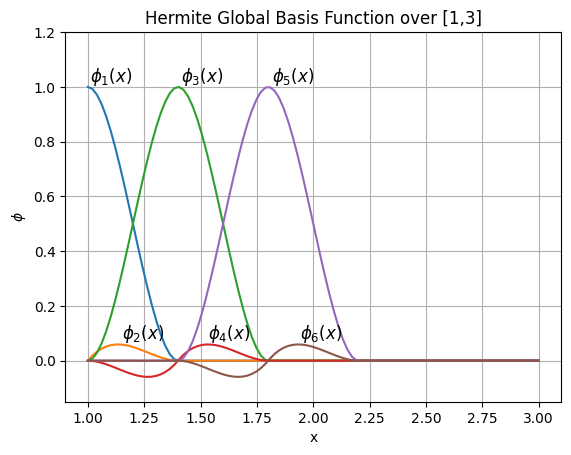

In [6]:
# visualization
a_vis = 1
b_vis = 3
n_vis = 6
nodes_vis = np.linspace(a_vis, b_vis, n_vis)
basis_vis = global_basis(nodes_vis)
# the first six Hermite global basis functions
phis_vis = [[] for _ in range(n_vis)]
x_vis = np.linspace(a_vis, b_vis, 100)

for i in range(n_vis):
    for x_ in x_vis:
        phis_vis[i].append(
            basis_vis.phi_i(i + 1, x_)
        )  # +1 because it should be phi_3 now to be consistent
        # it is due to the indexing convention in Python...
for r_ in range(n_vis):
    plt.plot(x_vis, phis_vis[r_])
    x__ = x_vis[np.argmax(phis_vis[r_])]
    y__ = np.max(phis_vis[r_])
    plt.text(x__ + 0.01, y__ + 0.02, rf"$\phi_{r_+1}(x)$", fontsize=12)

plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.ylim(-0.15, 1.2)
plt.title(f"Hermite Global Basis Function over [{a_vis},{b_vis}]")
plt.grid()

In [7]:
def GL4(f, a, b):
    """
    a:  the lower limit
    b:  the upper limit
    f:  the integrand
    """
    scalem, scalep = (b - a) / 2, (a + b) / 2
    node = [
        -np.sqrt((15 + 2 * np.sqrt(30)) / 35),
        -np.sqrt((15 - 2 * np.sqrt(30)) / 35),
        np.sqrt((15 - 2 * np.sqrt(30)) / 35),
        np.sqrt((15 + 2 * np.sqrt(30)) / 35),
    ]
    ws = [
        (18 - np.sqrt(30)) / 36,
        (18 + np.sqrt(30)) / 36,
        (18 + np.sqrt(30)) / 36,
        (18 - np.sqrt(30)) / 36,
    ]
    nodalval = [f(scalem * x_i + scalep) for x_i in node]
    result = scalem * np.dot(ws, nodalval)
    return result

### Construct the Linear System AU = F + B

This part is to construct the linear system $AU = F + B$, where

* $A$ is the stiffness matrix that is constructed via Hermite cubic local basis functions: $\{ \psi_{e_k,i,j} \rbrace_{i,j = 1, 2, 3, 4}$ where $e_k$ is the finite element corresponing to the subinterval $[x_k,x_{k+1}]$

* $\tilde{U}$ is the cofficient vector: $[b_1, b_2, U = \{U_i\rbrace_{i = 3}^{2n-2}, b_3, b_4]^T$. Hence, the approximated solution is $$u_h = \sum_{i = 1}^{2n} U_i\phi_i(x)$$

* $F$ is the global load vector that is constructed via local load vectors in the subintervals $e_k = [x_k, x_{k+1}]$

* $B$ is the Boundaries terms, $[\{ B_i \rbrace_{i = 3} ^{2n-2}] ^T$

#### Local stiffness matrix $A_k$
Starting from node $k = 2$ to node $k = n-1$. At each node, a $4 \ \text{x} \ 4$ matrix can be found.

Since the bilinear form is symmetric, $A_k$ is expected to be symmetric.

In [8]:
class local_info(global_basis):
    def __init__(self, nodes, E, f):
        super().__init__(nodes)
        self.cell_len = np.diff(nodes)
        self.E = E
        self.f = f

    def local_stiffness_matrix_general(self, k):
        """
        k:  the node index in Python convention

        k = 0 for x1
        k = 1 for x2
        k = 2 for x3
        .
        .
        .
        k = n-1 for xn

        """

        # at the kth subinterval [ x_k, x_{k + 1} ]
        # initialize a 4x4 empty matrix
        A_k = np.zeros((4, 4))
        # Assume that the nodes might not be evenly distributed
        x_k = self.nodes[k]
        h_k = self.nodes[k + 1] - self.nodes[k]

        ############################################################### using sp.integrate.quad #############################################################
        #####################################################################################################################################################

        # A_k[0] = [
        #     sp.integrate.quad(
        #         lambda x: N1_xx(x) * self.E(h_k * x + x_k) * N1_xx(x), 0, 1
        #     )[0],
        #     sp.integrate.quad(
        #         lambda x: N1_xx(x) * self.E(h_k * x + x_k) * N2_xx(x), 0, 1
        #     )[0]
        #     * h_k,
        #     sp.integrate.quad(
        #         lambda x: N1_xx(x) * self.E(h_k * x + x_k) * N3_xx(x), 0, 1
        #     )[0],
        #     sp.integrate.quad(
        #         lambda x: N1_xx(x) * self.E(h_k * x + x_k) * N4_xx(x), 0, 1
        #     )[0]
        #     * h_k,
        # ] / (h_k**3)

        # A_k[1] = [
        #     A_k[0][1] * h_k**3,
        #     sp.integrate.quad(
        #         lambda x: N2_xx(x) * self.E(h_k * x + x_k) * N2_xx(x), 0, 1
        #     )[0]
        #     * h_k**2,
        #     sp.integrate.quad(
        #         lambda x: N2_xx(x) * self.E(h_k * x + x_k) * N3_xx(x), 0, 1
        #     )[0]
        #     * h_k,
        #     sp.integrate.quad(
        #         lambda x: N2_xx(x) * self.E(h_k * x + x_k) * N4_xx(x), 0, 1
        #     )[0]
        #     * h_k**2,
        # ] / (h_k**3)

        # A_k[2] = [
        #     A_k[0][2] * h_k**3,
        #     A_k[1][2] * h_k**3,
        #     sp.integrate.quad(
        #         lambda x: N3_xx(x) * self.E(h_k * x + x_k) * N3_xx(x), 0, 1
        #     )[0],
        #     sp.integrate.quad(
        #         lambda x: N3_xx(x) * self.E(h_k * x + x_k) * N4_xx(x), 0, 1
        #     )[0]
        #     * h_k,
        # ] / (h_k**3)

        # A_k[3] = [
        #     A_k[0][-1] * h_k**3,
        #     A_k[1][-1] * h_k**3,
        #     A_k[2][-1] * h_k**3,
        #     sp.integrate.quad(
        #         lambda x: N4_xx(x) * self.E(h_k * x + x_k) * N4_xx(x), 0, 1
        #     )[0]
        #     * h_k**2,
        # ] / (h_k**3)

        ################################################################# using the gauss-legendre rule ##############################################
        ##############################################################################################################################################

        A_k[0] = [
            GL4(lambda x: N1_xx(x) * self.E(h_k * x + x_k) * N1_xx(x), 0, 1),
            GL4(lambda x: N1_xx(x) * self.E(h_k * x + x_k) * N2_xx(x), 0, 1) * h_k,
            GL4(lambda x: N1_xx(x) * self.E(h_k * x + x_k) * N3_xx(x), 0, 1),
            GL4(lambda x: N1_xx(x) * self.E(h_k * x + x_k) * N4_xx(x), 0, 1) * h_k,
        ] / (h_k**3)

        A_k[1] = [
            A_k[0][1] * h_k**3,
            GL4(lambda x: N2_xx(x) * self.E(h_k * x + x_k) * N2_xx(x), 0, 1) * h_k**2,
            GL4(lambda x: N2_xx(x) * self.E(h_k * x + x_k) * N3_xx(x), 0, 1) * h_k,
            GL4(lambda x: N2_xx(x) * self.E(h_k * x + x_k) * N4_xx(x), 0, 1) * h_k**2,
        ] / (h_k**3)

        A_k[2] = [
            A_k[0][2] * h_k**3,
            A_k[1][2] * h_k**3,
            GL4(lambda x: N3_xx(x) * self.E(h_k * x + x_k) * N3_xx(x), 0, 1),
            GL4(lambda x: N3_xx(x) * self.E(h_k * x + x_k) * N4_xx(x), 0, 1) * h_k,
        ] / (h_k**3)

        A_k[3] = [
            A_k[0][-1] * h_k**3,
            A_k[1][-1] * h_k**3,
            A_k[2][-1] * h_k**3,
            GL4(lambda x: N4_xx(x) * self.E(h_k * x + x_k) * N4_xx(x), 0, 1) * h_k**2,
        ] / (h_k**3)

        return A_k

    def local_stiffness_matrix_special(self, k):
        """
        Assume that E(x) is a (discontinuous) constant function.
        """
        h = self.cell_len[k]  # constant spacing
        A_k = np.array(
            [
                [12, 6 * h, -12, 6 * h],
                [6 * h, 4 * h**2, -6 * h, 2 * h**2],
                [-12, -6 * h, 12, -6 * h],
                [6 * h, 2 * h**2, -6 * h, 4 * h**2],
            ]
        ) * (self.E(self.nodes[k]) / h**3)
        return A_k

    def local_load_vector(self, k):
        b_k = np.zeros(4)

        xk = self.nodes[k]  # cell left endpoint
        h_k = self.nodes[k + 1] - self.nodes[k]  # element length

        b_k[0] = GL4(lambda x: N1(x) * self.f(x * h_k + xk), 0, 1) * h_k
        b_k[1] = GL4(lambda x: N2(x) * self.f(x * h_k + xk), 0, 1) * h_k**2
        b_k[2] = GL4(lambda x: N3(x) * self.f(x * h_k + xk), 0, 1) * h_k
        b_k[3] = GL4(lambda x: N4(x) * self.f(x * h_k + xk), 0, 1) * h_k**2

        # b_k[0] = sp.integrate.quadrature(lambda x:N1(x)*self.f(x*h_k + xk), 0,1)[0]*h_k
        # b_k[1] = sp.integrate.quadrature(lambda x:N2(x)*self.f(x*h_k + xk), 0,1)[0]*h_k**2
        # b_k[2] = sp.integrate.quadrature(lambda x:N3(x)*self.f(x*h_k + xk), 0,1)[0]*h_k
        # b_k[3] = sp.integrate.quadrature(lambda x:N4(x)*self.f(x*h_k + xk), 0,1)[0]*h_k**2

        return b_k

### Assembly to form the Linear System
Denote $n$ as the number of nodes
* $A \rightarrow \{a_{i,j}\rbrace_{i = 3,j = 3}^{2n - 2}$ 


* $\tilde{U} \rightarrow [b_1, b_2, U = \{U_i\rbrace_{i = 3}^{2n-2}, b_3, b_4]^T$


* $F \rightarrow \{b_i\rbrace _{i = 3}^{2n-2}$, $b_i$ being the local load vector over the subinterval $e_k$


* $B$ is the Boundaries terms, $[\{ B_i \rbrace_{i = 3} ^{2n-2}] ^T$, $B_i = -b_1a_{i,1} -b_2a_{i,2} - b_3a_{i,2n-1} - b_4a_{i,2n}$

In [9]:
class Hermite_solver_ground(local_info):
    def __init__(self, nodes, E, f, BCs):
        super().__init__(nodes, E, f)
        self.bcs = BCs

    def stiffness_matrix_general(self):
        A = np.zeros(((2 * self.n - 4), (2 * self.n - 4)))
        for k_ in range(1, self.n - 2, 1):
            A_k = self.local_stiffness_matrix_general(k_)
            idx_l = (k_ + 1) * 2 - 1 - 3
            idx_r = (k_ + 1) * 2 + 2 - 3
            # k_ + 1 to get the node index starting from 1 to n
            # Under this notation, each kth node has its submatrix in the
            # the global stiffness matrix from 2k - 1 to 2k + 1
            # since the global stiffness matrix starts from i,j = 3
            # we need to minus 3 to shift the indices to fit Python
            A[idx_l : idx_r + 1, idx_l : idx_r + 1] += A_k

        # Contribution from node 1
        A[0:2, 0:2] += self.local_stiffness_matrix_general(k=0)[2:, 2:]
        # constribution from node n
        A[-2:, -2:] += self.local_stiffness_matrix_general(k=-2)[0:2, 0:2]

        return A

    def stiffness_matrix_special(self):
        A = np.zeros(((2 * self.n - 4), (2 * self.n - 4)))
        for k_ in range(1, self.n - 2, 1):
            A_k = self.local_stiffness_matrix_special(k_)
            idx_l = (k_ + 1) * 2 - 1 - 3
            idx_r = (k_ + 1) * 2 + 2 - 3
            # k_ + 1 to get the node index starting from 1 to n
            # Under this notation, each kth node has its submatrix in the
            # the global stiffness matrix from 2k - 1 to 2k + 1
            # since the global stiffness matrix starts from i,j = 3
            # we need to minus 3 to shift the indices to fit Python
            A[idx_l : idx_r + 1, idx_l : idx_r + 1] += A_k

        # Contribution from node 1
        A[0:2, 0:2] += self.local_stiffness_matrix_special(k=0)[2:, 2:]

        # constribution from node n
        A[-2:, -2:] += self.local_stiffness_matrix_special(k=-2)[0:2, 0:2]
        return A

    def global_load_vector(self):
        F = np.zeros(2 * self.n - 4)
        for k_ in range(1, self.n - 2, 1):
            b_k = self.local_load_vector(k_)
            idx_l = (k_ + 1) * 2 - 1 - 3
            idx_r = (k_ + 1) * 2 + 2 - 3
            F[idx_l : idx_r + 1] += b_k
        F[0:2] += self.local_load_vector(k=1)[2:]
        F[-2:] += self.local_load_vector(k=-2)[0:2]

        return F

    def Boundary(self):
        B = np.zeros(2 * self.n - 4)
        I_31 = (
            GL4(
                lambda x: N3_xx(x)
                * self.E((self.cell_len[0] * x + self.nodes[0]))
                * N1_xx(x),
                0,
                1,
            )
            / (self.cell_len[0]) ** 3
        )
        I_32 = (
            GL4(
                lambda x: N3_xx(x)
                * self.E((self.cell_len[0] * x + self.nodes[0]))
                * N2_xx(x),
                0,
                1,
            )
            / (self.cell_len[0]) ** 2
        )
        B[0] = -self.bcs[0] * I_31 - self.bcs[1] * I_32

        I_41 = (
            GL4(
                lambda x: N4_xx(x)
                * self.E((self.cell_len[0] * x + self.nodes[0]))
                * N1_xx(x),
                0,
                1,
            )
            / (self.cell_len[0]) ** 2
        )
        I_42 = GL4(
            lambda x: N4_xx(x)
            * self.E((self.cell_len[0] * x + self.nodes[0]))
            * N2_xx(x),
            0,
            1,
        ) / (self.cell_len[0])
        B[1] = -self.bcs[0] * I_41 - self.bcs[1] * I_42

        Im31 = (
            GL4(
                lambda x: N3_xx(x)
                * self.E((self.cell_len[-1] * x + self.nodes[-2]))
                * N1_xx(x),
                0,
                1,
            )
            / (self.cell_len[-1]) ** 3
        )
        Im30 = (
            GL4(
                lambda x: N4_xx(x)
                * self.E((self.cell_len[-1] * x + self.nodes[-2]))
                * N1_xx(x),
                0,
                1,
            )
            / (self.cell_len[-1]) ** 2
        )
        B[-2] = -self.bcs[-2] * Im31 - self.bcs[-1] * Im30

        Im21 = (
            GL4(
                lambda x: N3_xx(x)
                * self.E((self.cell_len[-1] * x + self.nodes[-2]))
                * N2_xx(x),
                0,
                1,
            )
            / (self.cell_len[-1]) ** 2
        )
        Im20 = GL4(
            lambda x: N4_xx(x)
            * self.E((self.cell_len[-1] * x + self.nodes[-2]))
            * N2_xx(x),
            0,
            1,
        ) / (self.cell_len[-1])
        B[-1] = -self.bcs[-2] * Im21 - self.bcs[-1] * Im20
        return B

    def gotcha_general(self):
        U = np.linalg.solve(
            self.stiffness_matrix_general(), self.global_load_vector() + self.Boundary()
        )

        return U

    def gotcha_special(self):
        U = np.linalg.solve(
            self.stiffness_matrix_special(), self.global_load_vector() + self.Boundary()
        )
        return U

    def soln(self, coeff, x):
        U = np.concatenate((self.bcs[0:2], coeff, self.bcs[2:]))
        uh = lambda x: np.sum([U[i] * self.phi_i(i + 1, x) for i in range(len(U))])
        evaluation = []
        for x_ in x:
            evaluation.append(uh(x_))
        return evaluation

In [10]:
def Hermite_solver(a, b, num_of_nodes: list, E, f, bcs: list, disctn: list, type=None):
    """
    Inputs:

    a:              The left endpoint of the interval in which  x lies

    b:              The right endpoint of the interval in which x lies

    num_nodes:      The number of nodes [ num_of nodes in [a, disctn1], ... ]

    E:              E(x)

    f:              The forcing function on the rhs of the ODE

    bcs:            Boundary conditions

    disctn:         The list that contains where the discontinuities show up along x axis:
                    if the disctn appears at x = a, b, c, then disctn = [a, b, c]

    Type:           = special/general, depending on whether E(x) depends on x

    This function solves (Eu'')'' = f using the foundational Hermite solver constructed previously.

    Nodes will be constructed using a and b

    Output:
    The numerical solution uh on a < x < b

    """
    if disctn == None:
        points = [a] + [b]
        num_of_disctn = 0  # number of discontinuities
    else:
        points = [a] + [disctn] + [b]  # [a, disctn1, ... , b]
        num_of_disctn = len(disctn)  # number of discontinuities

    if num_of_disctn == 0:
        nodes = np.linspace(a, b, num_of_nodes[0])
        Hermite_solver_ = Hermite_solver_ground(nodes, E, f, bcs)

        U = getattr(Hermite_solver_, f"gotcha_{type}")()
        uh = Hermite_solver_.soln(U, nodes)
        return uh, nodes
    else:
        # Set up the nodes between each discontinuity
        nodes = np.linspace(points[0], points[1], num_of_nodes[0])
        for i in range(1, len(points) - 1, 1):
            nodes = np.concatenate(
                (nodes, np.linspace(points[i], points[i + 1], num_of_nodes[i]))
            )
        nodes = np.unique(nodes)

        Hermite_solver_ = Hermite_solver_ground(nodes, E, f, bcs)

        U = getattr(Hermite_solver_, f"gotcha_{type}")()
        uh = Hermite_solver_.soln(U, nodes)
        return uh, nodes

### Numerical Experiments

* Case 1:


Solve $$u^{\prime \prime \prime \prime} = 2x = f(x)$$ with the boundary conditions being $$u(-\pi) = b_1 = 0 , u^{\prime}(-\pi) = b_2 = 0, u(\pi) = b_3 = 0, u^{\prime}(\pi) = b_4 = 0$$ over $\Omega = (-\pi, \pi)$

The exact solution is $$u(x) = \frac{1}{60}x(\pi^2 - x^2)^2$$

In [11]:
# exact solution
u_1 = lambda x: x * (np.pi**2 - x**2) ** 2 / 60

E_1 = lambda x: 1

f_1 = lambda x: 2 * x

x_1 = np.linspace(-np.pi, np.pi, 150)

bcs_1 = [0, 0, 0, 0]

# since in this case E is constant and nodes are evenly distributed
uh_1, nodes_1 = Hermite_solver(-np.pi, np.pi, [15], E_1, f_1, bcs_1, None, "special")

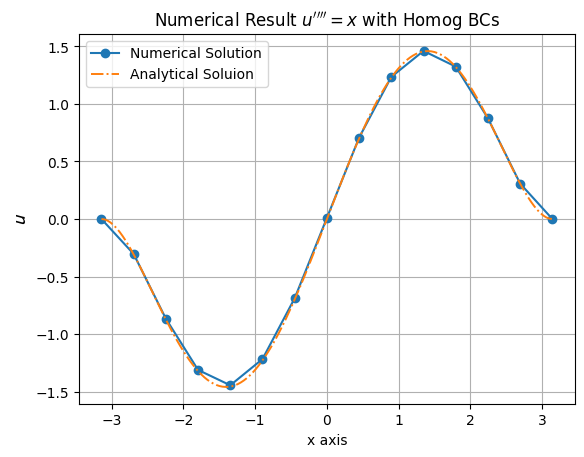

In [12]:
plt.plot(nodes_1, uh_1, "-o", label="Numerical Solution")
plt.plot(x_1, u_1(x_1), linestyle="dashdot", linewidth=1.4, label="Analytical Soluion")
plt.xlabel("x axis", fontsize=10)
plt.ylabel(r"$\mathcal{u}$", fontsize=15)
plt.title(r"Numerical Result $u^{\prime \prime \prime \prime} = x $ with Homog BCs")
plt.legend()
plt.grid()

* Case 2 (Inhomogeneous):


Solve $$u^{\prime \prime \prime \prime} = \sin(x) = f(x)$$ with the boundary conditions being $$u(-\pi) = b_1 = 0 , u^{\prime}(-\pi) = b_2 = 2, u(\pi) = b_3 = \pi, u^{\prime}(\pi) = b_4 = 1$$ over $\Omega = (-\pi, \pi)$

The exact solution is $$u(x) = \frac{x^3}{\pi^2} - \frac{x^2}{4\pi} - \frac{x}{2} + \sin(x) + \frac{3\pi}{4}$$

In [13]:
# exact solution
u_2 = (
    lambda x: x**3 / np.pi**2
    - x**2 / (4 * np.pi)
    - x / 2
    + np.sin(x)
    + 3 * np.pi / 4
)

E_2 = lambda x: 1
f_2 = lambda x: np.sin(x)

x_2 = np.linspace(-np.pi, np.pi, 100)
bcs_2 = [0, 2, np.pi, 1]

# since in this case E is constant and nodes are evenly distributed
uh_2, nodes_2 = Hermite_solver(
    a=-np.pi,
    b=np.pi,
    num_of_nodes=[15],
    E=E_2,
    f=f_2,
    bcs=bcs_2,
    disctn=None,
    type="special",
)

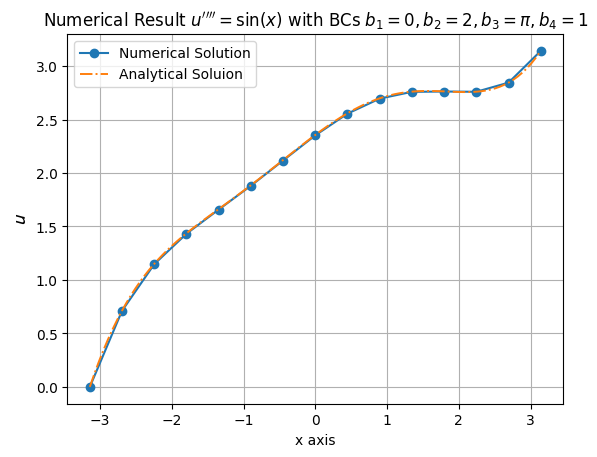

In [14]:
plt.plot(nodes_2, uh_2, "-o", label="Numerical Solution")
plt.plot(x_2, u_2(x_2), linestyle="dashdot", linewidth=1.4, label="Analytical Soluion")
plt.xlabel("x axis", fontsize=10)
plt.ylabel(r"$\mathcal{u}$", fontsize=15)
plt.title(
    r"Numerical Result $u^{\prime \prime \prime \prime} = \sin(x) $ with BCs $b_1 = 0, b_2 = 2, b_3 = \pi, b_4 = 1$"
)
plt.legend()
plt.grid()

* Case 3 (Inhomogeneous & Continuous $E(x) = x$):

Solve $$(x u^{\prime \prime})^{\prime \prime} = 0 = f(x)$$ with the boundary conditions being $$u(1) = b_1 = 0 , u^{\prime}(1) = b_2 = 1, u(2) = b_3 = 0, u^{\prime}(2) = b_4 = 1$$ over $\Omega = (1, 2)$

The exact solution is $$u(x) = \frac{(x^2 + x - 2)\log(2) - 2x\log(x)}{\log(8) - 2} $$
<!-- Solve $$(x u^{\prime \prime})^{\prime \prime} = -2\cos(x) + x\sin(x) = f(x)$$ with the boundary conditions being $$u(1) = b_1 = \sin(1) , u^{\prime}(1) = b_2 = \cos(1), u(\pi) = b_3 = 0, u^{\prime}(\pi) = b_4 = -1$$ over $\Omega = (1, \pi)$

The exact solution is $$u(x) = \sin(x) $$ -->

In [15]:
# exact solution
u_3 = lambda x: ((x**2 + x - 2) * np.log(2) - 2 * x * np.log(x)) / (np.log(8) - 2)

E_3 = lambda x: x

f_3 = lambda x: 0

x_3 = np.linspace(1, 2, 150)

bcs_3 = [0, 1, 0, 1]

# E is a continous function
uh_3, nodes_3 = Hermite_solver(
    a=1, b=2, num_of_nodes=[20], E=E_3, f=f_3, bcs=bcs_3, disctn=None, type="general"
)

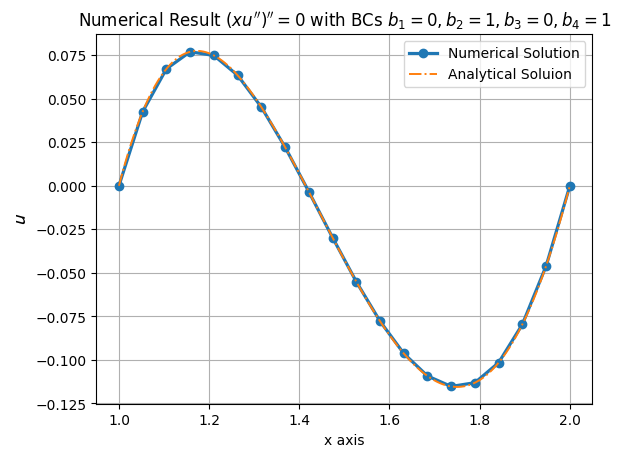

In [16]:
plt.plot(nodes_3, uh_3, "-o", linewidth=2.3, label="Numerical Solution")
plt.plot(x_3, u_3(x_3), linestyle="dashdot", linewidth=1.4, label="Analytical Soluion")
plt.xlabel("x axis", fontsize=10)
plt.ylabel(r"$\mathcal{u}$", fontsize=15)
plt.title(
    r"Numerical Result $(xu^{\prime \prime})^{\prime \prime} = 0 $ with BCs $b_1 = 0, b_2 = 1, b_3 = 0, b_4 = 1$"
)
plt.legend()
plt.grid()

* Case 4 ( $ \ $ Discontinuous $E(x) = \begin{cases} \frac{1}{120} & \ \text{if} \ 0 \leq x < 2 \\ \frac{1}{24} & \ \text{if} \ 2 \leq x \leq 4 \end{cases}$ $ \ $ ):

Solve $$(E(x)u^{\prime \prime})^{\prime \prime} = 1 $$ with the boundary conditions being $$u(0) = b_1 = 0 , u^{\prime}(0) = b_2 = 0, u(4) = b_3 = 1, u^{\prime}(4) = b_4 = 1$$ over $\Omega = (0, 4)$

Since we have assumed that $E(x)$ is a discontinous constant function, we can rewrite the problem as: $$u^{\prime \prime \prime \prime} = \mathcal{f}(x) = \begin{cases} 120 & \ \text{if} \ 0 \leq x < 2 \\ 24 & \ \text{if} \ 2 \leq x \leq 4 \end{cases}$$ with the Boundary Conditions being $$u(0) = b_1 =0 , u^{\prime}(0) = b_2 = 0, u(4) = b_3 = 1, u^{\prime}(4) = b_4 = 1$$ over $\Omega = (0, 4)$ with $E(x) = 1$ now. This is equivalent to the **Discontinous $\mathcal{f}(x)$**.


The exact solution is $$u(x) = \begin{cases} 5x^4 - \frac{1087}{32}x^3 + \frac{959}{16}x^2 & \ \text{if} \ 0 \leq x < 2 \\ (x-4)^4 + \frac{449}{32}(x-4)^3 + \frac{581}{16}(x-4)^2 + (x-4) + 1 & \ \text{if} \ 2 \leq x \leq 4 \end{cases}$$

In [17]:
# exact solution
def u_4(x):
    if 0 <= x < 2:
        return 5 * x**4 - (1087 / 32) * x**3 + (959 / 16) * x**2
    elif 2 <= x <= 4:
        return (
            (x - 4) ** 4
            + (449 / 32) * (x - 4) ** 3
            + (581 / 16) * (x - 4) ** 2
            + (x - 4)
            + 1
        )


E_4 = lambda x: 1


def f_4(x):
    if 0 <= x < 2:
        return 120
    elif 2 <= x <= 4:
        return 24


x_4 = np.linspace(0, 4, 150)
bcs_4 = [0, 0, 1, 1]

# E is a discontinuous const function
uh_4, nodes_4 = Hermite_solver(
    a=0, b=4, num_of_nodes=[10, 10], E=E_4, f=f_4, bcs=bcs_4, disctn=[2], type="special"
)

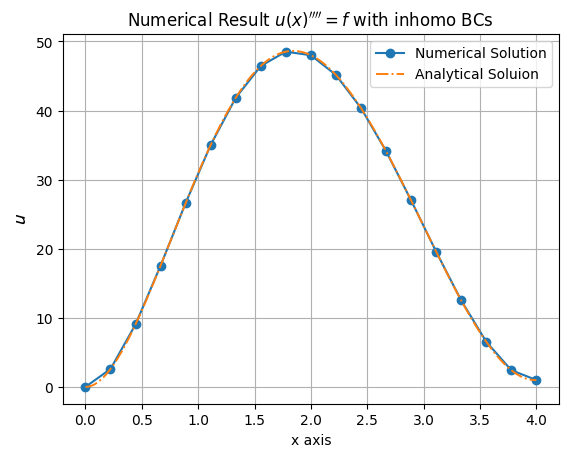

In [18]:
plt.plot(nodes_4, uh_4, "-o", label="Numerical Solution")
plt.plot(
    x_4,
    [u_4(_) for _ in x_4],
    linestyle="dashdot",
    linewidth=1.4,
    label="Analytical Soluion",
)
plt.xlabel("x axis", fontsize=10)
plt.ylabel(r"$\mathcal{u}$", fontsize=15)
plt.title(r"Numerical Result $u(x)^{\prime \prime \prime \prime} = f $ with inhomo BCs")
plt.legend()
plt.grid()

# Error Analysis
Let $\mathcal{T}$ be a triangulation of $\Omega \subset \mathbf{R}^n$ with finite elements $(\mathbf{K}_j, \mathbf{\mathcal{P}}_j, \mathbf{\mathcal{L}}_j)$, such that the shape constant $\sigma_j$ of $\mathbf{K}_j$ satisfied $\sigma_j > 0$, and such that the nodal variables $\mathbf{\mathcal{L}}$ involve only evaluations of functions or evaluations of derivatives of degree $\leq l$, and $\mathbf{\mathcal{P}}$ contains all polynomials of degree $k$ and below, with $k > l + \frac{n}{2}$. Let $u\in C^{k+1}(\Omega)$. Let $h$ be the maximum over all of the triangle diameters, with $ 0 \leq h < 1$. Then for $i \leq k$,
    the global interpolation $\mathcal{I}_h$ satisfies $$\| \mathcal{I}_hu - u \|_{H^i(\Omega)} \leq Ch^{k + 1 - i}|u|_{H^{k+1}(\Omega)}$$, where $C$ is a generic constant independent of $h$ 

In the current case, we have $ k = 3, \mathcal{l} = 1, n = 1$ and hence:

* $i = 0$: $\| \mathcal{I}_hu - u \|_{L^2(\Omega)} \leq Ch^{4}|u|_{H^{4}(\Omega)} \Rightarrow \| \mathcal{I}_hu - u \|_{L^2(\Omega)} = \mathcal{O}(h^4) $ 
* $i = 1$: $\| \mathcal{I}_hu - u \|_{H^1(\Omega)} \leq Ch^{3}|u|_{H^{4}(\Omega)} \Rightarrow \| \mathcal{I}_hu - u \|_{H^1(\Omega)} = \mathcal{O}(h^3) $ 
* $i = 2$: $\| \mathcal{I}_hu - u \|_{H^2(\Omega)} \leq Ch^{2}|u|_{H^{4}(\Omega)} \Rightarrow \| \mathcal{I}_hu - u \|_{H^2(\Omega)} = \mathcal{O}(h^2) $ 

We will verify the convergence using 4 cases:

* $\mathcal{f_1}(x) = 2x$ and the solution is $$u(x) = \frac{1}{60}x(\pi^2 - x^2)^2 $$ over $\Omega = (-\pi,\pi)$ with homogeneous Boundary Conditions

* $\mathcal{f_2} = \sin(x)$ and the solution is $$u(x) = \frac{x^3}{\pi^2} - \frac{x^2}{4\pi} - \frac{x}{2} + \sin(x) + \frac{3\pi}{4}$$ over $\Omega = (-\pi,\pi)$ with Boundary Conditions as $u(-\pi) = b_1 = 0 , u^{\prime}(-\pi) = b_2 = 2, u(\pi) = b_3 = \pi, u^{\prime}(\pi) = b_4 = 1$

* $\mathcal{f_3} = \frac{-2}{25}(-\sin^2(x) + \cos^2(x) - 3)$ and the solution is $$u(x) = \frac{(x^2 - \pi^2)^2 + \sin^2(x) + 1}{100}$$ over $\Omega = (-\pi,\pi)$ with Boundary Conditions being $u(-\pi) = b_1 = \frac{1}{100} , u^{\prime}(-\pi) = b_2 = 0, u(\pi) = b_3 = \frac{1}{100}, u^{\prime}(\pi) = b_4 = 0$

* $\mathcal{f_4} = \frac{2}{15}\sin(3-x)\sinh(x+3)$ and the solution is $$u(x) = \frac{1}{30}\sin(x-3)\sinh(x+3)$$ over $\Omega = (-3,3)$ with Boundary Conditions being $u(-3) = b_1 = 0 , u^{\prime}(-3) = b_2 =\frac{1}{30} \sin(-6)\cosh(0), u(3) = b_3 = 0, u^{\prime}(3) = b_4 = \frac{1}{30}\sinh(6)$

### Norm Notation

* $L^2 \ \text{norm}$: $\| u - \mathcal{I}_hu \|_{L^2(\Omega)} \ = \| u - u_h \|_{L^2(\Omega)} \ = [ \int_{\Omega} \ ( \ u(x) - \sum_{i = 1}^{2n} \ U_i\phi_i(x) \ )^2 dx ]^{1/2}$

* $H^i \ \text{semi-norm}$: $| u - \mathcal{I}_hu |_{H^i(\Omega)} \ = | u - u_h |_{H^i(\Omega)} \ = [ \int_{\Omega} \ ( \ u^{(i)}(x) - \sum_{j = 1}^{2n} \ U_j\phi_j^{(i)}(x) \ )^2 dx ]^{1/2}$

In [19]:
def error_L2(
    u_true, num_of_nodes: int, E, f, bcs: list, bound: list, type="special", disctn=None
):
    """
    Inputs:
    u_true:         The exact solution u(x)
    num_of_nodes:   The number of nodes used in Omega
    E:              E(x)
    f:              f(x)
    bcs:            Boundary conditions [ b1, b2, b3, b4]
    bound:          [ a, b]
    """
    # set up the Hermite solver
    if disctn == None:
        nodes = np.linspace(bound[0], bound[1], num_of_nodes)
    else:
        points = [bound[0]] + [disctn] + [bound[1]]
        nodes = np.linspace(points[0], points[1], num_of_nodes)
        for i in range(1, len(points) - 1, 1):
            nodes = np.concatenate(
                (nodes, np.linspace(points[i], points[i + 1], num_of_nodes))
            )
        nodes = np.unique(nodes)

    HS = Hermite_solver_ground(nodes=nodes, E=E, f=f, BCs=bcs)
    # fetch the coefficients Ui
    coeff = getattr(HS, f"gotcha_{type}")()
    # concentate with the bi
    us = np.concatenate((bcs[0:2], coeff, bcs[2:]))

    L2Error = 0
    # perform numerical integration per sub-interval
    for k in range(num_of_nodes - 1):
        idx = 2 * (k + 1) - 1
        uh = lambda x: np.sum(
            [us[idx - 1 + j] * HS.phi_i(idx + j, x) for j in range(4)]
        )
        error = sp.integrate.quad(
            lambda x: (uh(x) - u_true(x)) ** 2, nodes[k], nodes[k + 1]
        )[0]
        L2Error += error
    return L2Error ** (1 / 2)

In [20]:
def error_H1_semi_norm(
    u_true_x, num_of_nodes: int, E, f, bcs: list, bound: list, type="special"
):
    """
    Inputs:
    u_true_x:       The 1st derivative of the exact solution u(x)
    num_of_nodes:   The number of nodes used in Omega
    E:              E(x)
    f:              f(x)
    bcs:            Boundary conditions [ b1, b2, b3, b4]
    bound:          [ a, b]
    """
    # set up the Hermite solver
    nodes = np.linspace(bound[0], bound[1], num_of_nodes)
    HS = Hermite_solver_ground(nodes=nodes, E=E, f=f, BCs=bcs)
    # fetch the coefficients Ui
    coeff = getattr(HS, f"gotcha_{type}")()
    # concentate with the bi
    us = np.concatenate((bcs[0:2], coeff, bcs[2:]))

    H1semiError = 0
    # perform numerical integration per sub-interval
    for k in range(num_of_nodes - 1):
        idx = 2 * (k + 1) - 1
        uh_x = lambda x: np.sum(
            [us[idx - 1 + j] * HS.phi_ix(idx + j, x) for j in range(4)]
        )
        error = sp.integrate.quad(
            lambda x: (uh_x(x) - u_true_x(x)) ** 2, nodes[k], nodes[k + 1]
        )[0]
        H1semiError += error
    return H1semiError ** (1 / 2)

In [21]:
def error_H2_semi_norm(
    u_true_xx, num_of_nodes: int, E, f, bcs: list, bound: list, type="special"
):
    """
    Inputs:
    u_true_xx:       The 2nd derivative of the exact solution u(x)
    num_of_nodes:   The number of nodes used in Omega
    E:              E(x)
    f:              f(x)
    bcs:            Boundary conditions [ b1, b2, b3, b4]
    bound:          [ a, b]
    """
    # set up the Hermite solver
    nodes = np.linspace(bound[0], bound[1], num_of_nodes)
    HS = Hermite_solver_ground(nodes=nodes, E=E, f=f, BCs=bcs)
    # fetch the coefficients Ui
    coeff = getattr(HS, f"gotcha_{type}")()
    # concentate with the bi
    us = np.concatenate((bcs[0:2], coeff, bcs[2:]))

    H2semiError = 0
    # perform numerical integration per sub-interval
    for k in range(num_of_nodes - 1):
        idx = 2 * (k + 1) - 1
        uh_xx = lambda x: np.sum(
            [us[idx - 1 + j] * HS.phi_ixx(idx + j, x) for j in range(4)]
        )
        error = sp.integrate.quad(
            lambda x: (uh_xx(x) - u_true_xx(x)) ** 2, nodes[k], nodes[k + 1]
        )[0]
        H2semiError += error
    return H2semiError ** (1 / 2)

In [22]:
# RHS forcing terms
f1 = f_1
f2 = f_2
f3 = lambda x: -2 * (-np.sin(x) ** 2 + np.cos(x) ** 2 - 3) / 25
f4 = lambda x: np.sin(3 - x) * np.sinh(x + 3) * 2 / 15
fs = [f1, f2, f3, f4]

# True solutions
u1_true = u_1
u2_true = u_2
u3_true = lambda x: ((x**2 - np.pi**2) ** 2 + np.sin(x) ** 2 + 1) / 100
u4_true = lambda x: np.sin(x - 3) * np.sinh(x + 3) / 30
us = [u1_true, u2_true, u3_true, u4_true]

# 1st derivates of the true solutions
u1_true_x = lambda x: (5 * x**4 - 6 * np.pi**2 * x**2 + np.pi**4) / 60
u2_true_x = lambda x: np.cos(x) - (-6 * x**2 + np.pi * x + np.pi**2) / (
    2 * np.pi**2
)
u3_true_x = lambda x: (2 * x**3 - 2 * x * np.pi**2 + np.sin(x) * np.cos(x)) / 50
u4_true_x = (
    lambda x: (np.cos(x - 3) * np.sinh(x + 3) + np.sin(x - 3) * np.cosh(x + 3)) / 30
)
us_x = [u1_true_x, u2_true_x, u3_true_x, u4_true_x]

# 2nd derivatives of the true solutions
u1_true_xx = lambda x: x**3 / 3 - np.pi**2 * x / 5
u2_true_xx = lambda x: -(np.pi - 12 * x) / (2 * np.pi**2) - np.sin(x)
u3_true_xx = (
    lambda x: (6 * x**2 - np.sin(x) ** 2 + np.cos(x) ** 2 - 2 * np.pi**2) / 50
)
u4_true_xx = lambda x: np.cos(x - 3) * np.cosh(x + 3) / 15
us_xx = [u1_true_xx, u2_true_xx, u3_true_xx, u4_true_xx]

# Bounds and Boundary conditions
bounds = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-3, 3]]
bcs = [
    [0, 0, 0, 0],
    [0, 2, np.pi, 1],
    [1 / 100, 0, 1 / 100, 0],
    [0, np.sin(-6) * np.cosh(0) / 30, 0, np.sinh(6) / 30],
]
E = lambda x: 1

In [23]:
num_of_nodes = [80, 100, 110, 120, 130, 140, 150, 160]

L2_error = [[] for _ in range(4)]
H1_semierror = [[] for _ in range(4)]
H2_semierror = [[] for _ in range(4)]

h = [[] for _ in range(4)]

for iter in range(4):
    h_ = [
        (bounds[iter][1] - bounds[iter][0]) / (num_of_nodes[i] - 1)
        for i in range(len(num_of_nodes))
    ]
    h[iter] = h_

In [24]:
for iter in tqdm(range(4)):
    for n_ in num_of_nodes:
        # iterate for each number of nodes
        # L2
        l2 = error_L2(us[iter], n_, E, fs[iter], bcs[iter], bounds[iter])
        L2_error[iter].append(l2)

        # H1 semi-norm
        h1semi = error_H1_semi_norm(
            us_x[iter], n_, E, fs[iter], bcs[iter], bounds[iter]
        )
        H1_semierror[iter].append(h1semi)

        # H2 semi-norm
        h2semi = error_H2_semi_norm(
            us_xx[iter], n_, E, fs[iter], bcs[iter], bounds[iter]
        )
        H2_semierror[iter].append(h2semi)

100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


In [25]:
H1_error = [[] for _ in range(4)]
H2_error = [[] for _ in range(4)]
for iter in range(4):
    for i in range(len(num_of_nodes)):
        H1_error[iter].append(
            (L2_error[iter][i] ** 2 + H1_semierror[iter][i] ** 2) ** (1 / 2)
        )
        H2_error[iter].append(
            (
                L2_error[iter][i] ** 2
                + H1_semierror[iter][i] ** 2
                + H2_semierror[iter][i] ** 2
            )
            ** (1 / 2)
        )

Text(0.5, 1.0, '(d) $H^2-norm \\ \\text{error}$')

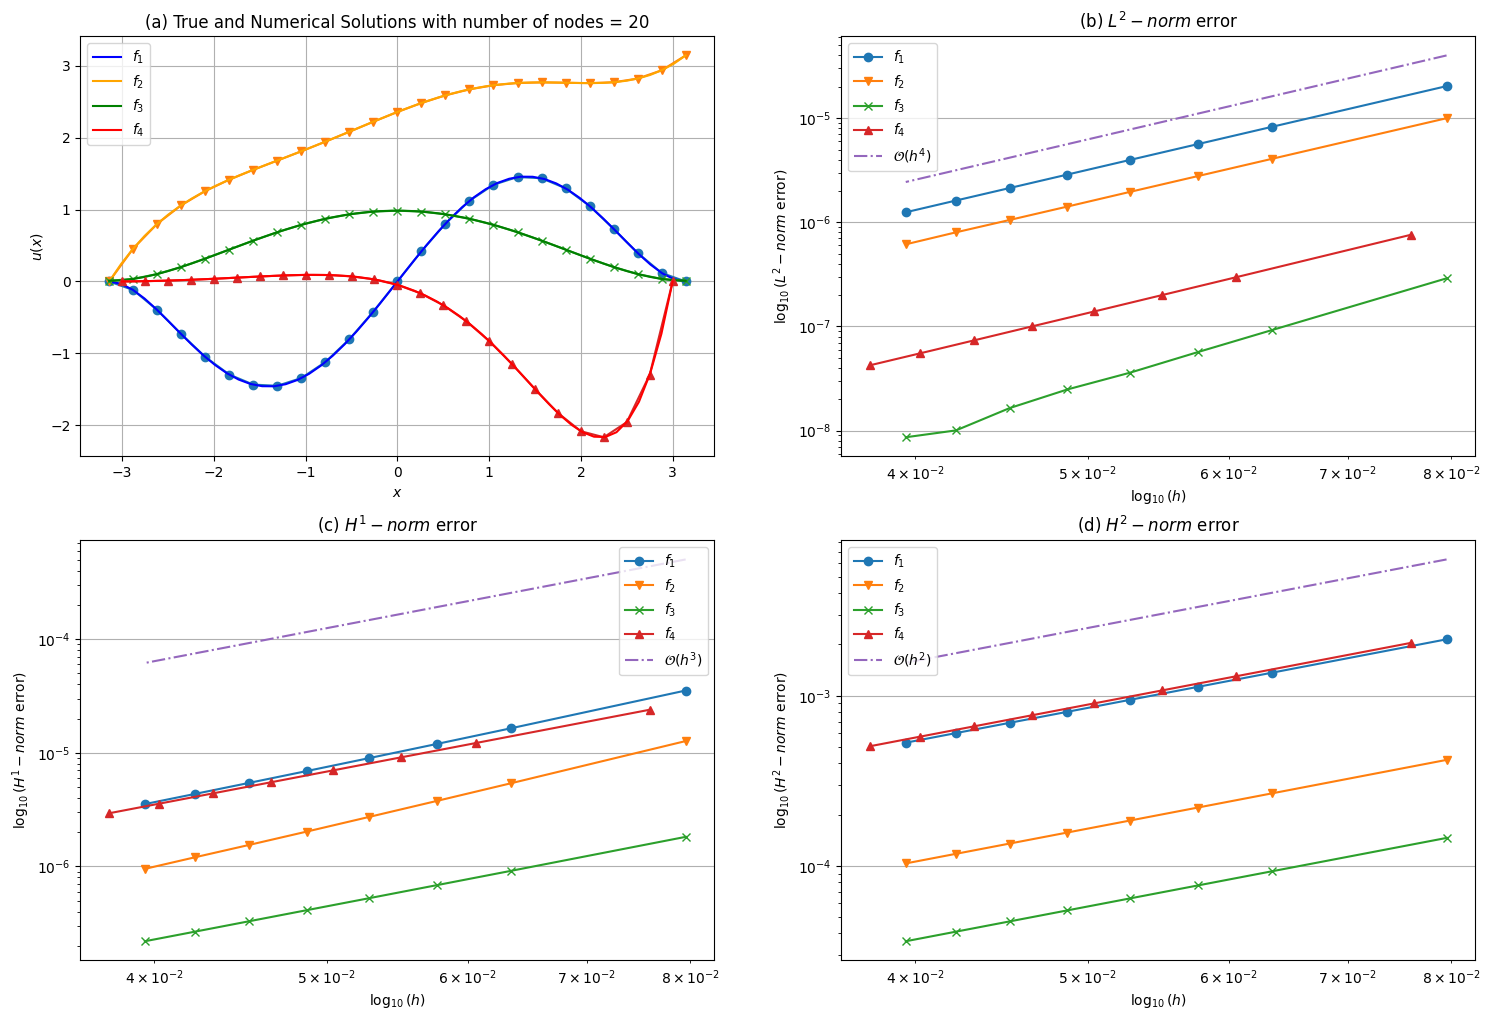

In [26]:
figs, axes = plt.subplots(2, 2, figsize=(18, 12))
marker = ["-o", "-v", "-x", "-^"]
color = ["b", "orange", "g", "r"]
####################################################################################################################################################
# axes[0,0] - Plot of numerical solutions
uh = []
for ii in range(4):
    uh_, _ = Hermite_solver(
        bounds[ii][0], bounds[ii][1], [25], E, fs[ii], bcs[ii], None, "special"
    )
    uh.append(uh_)

# nodes from -pi to pi
node_pi = np.linspace(-np.pi, np.pi, 25)
x_pi = np.linspace(-np.pi, np.pi, 50)
# nodes from -3 to 3
node_last = np.linspace(-3, 3, 25)
x_last = np.linspace(-3, 3, 50)
color = ["b", "orange", "g", "r"]
for iter in range(0, 4, 1):
    if iter == 3:
        axes[0, 0].plot(node_last, uh[iter], marker[iter])
        axes[0, 0].plot(x_last, us[iter](x_last), color[iter], label=rf"$f_{iter + 1}$")
    else:
        axes[0, 0].plot(node_pi, uh[iter], marker[iter])
        axes[0, 0].plot(x_pi, us[iter](x_pi), color[iter], label=rf"$f_{iter + 1}$")

axes[0, 0].legend(loc="best")
axes[0, 0].grid()
axes[0, 0].set_xlabel(r"$x$")
axes[0, 0].set_ylabel(r"$u(x)$")
axes[0, 0].set_title(r"(a) True and Numerical Solutions with number of nodes = 20")

####################################################################################################################################################
# axes[0,1] - l2
for iter in range(4):
    axes[0, 1].loglog(h[iter], L2_error[iter], marker[iter], label=rf"$f_{iter + 1}$")
axes[0, 1].loglog(
    h[0],
    [h[0][i] ** 4 for i in range(len(num_of_nodes))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^4)$",
)

axes[0, 1].legend(loc="best")
axes[0, 1].grid()
axes[0, 1].set_xlabel(r"$\log_{10}(h)$")
axes[0, 1].set_ylabel(r"$\log_{10}(L^2-norm \ \text{error})$")
axes[0, 1].set_title(r"(b) $L^2-norm\ \text{error}$")

####################################################################################################################################################
# axes[1,0] - H1
for iter in range(4):
    axes[1, 0].loglog(h[iter], H1_error[iter], marker[iter], label=rf"$f_{iter + 1}$")
axes[1, 0].loglog(
    h[0],
    [h[0][i] ** 3 for i in range(len(num_of_nodes))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^3)$",
)

axes[1, 0].legend(loc="best")
axes[1, 0].grid()
axes[1, 0].set_xlabel(r"$\log_{10}(h)$")
axes[1, 0].set_ylabel(r"$\log_{10}(H^1-norm \ \text{error})$")
axes[1, 0].set_title(r"(c) $H^1-norm \ \text{error}$")

# ####################################################################################################################################################
# axes[1,0] - H2
for iter in range(4):
    axes[1, 1].loglog(h[iter], H2_error[iter], marker[iter], label=rf"$f_{iter + 1}$")

axes[1, 1].loglog(
    h[0],
    [h[0][i] ** 2 for i in range(len(num_of_nodes))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^2)$",
)
# axes[1,1].loglog(h[-1],[h[-1][i]**2 for i in range(len(num_of_nodes))],linestyle = 'dashdot', label = r'$\mathcal{O}(h^4)$')
axes[1, 1].legend(loc="best")
axes[1, 1].grid()
axes[1, 1].set_xlabel(r"$\log_{10}(h)$")
axes[1, 1].set_ylabel(r"$\log_{10}(H^2 - norm \ \text{error})$")
axes[1, 1].set_title(r"(d) $H^2-norm \ \text{error}$")

* Discontinous Case Error Bound

Consider $$u^{\prime \prime \prime \prime} = \mathcal{f}(x) = \begin{cases} 120 & \ \text{if} \ 0 \leq x < 2 \\ 24 & \ \text{if} \ 2 \leq x \leq 4 \end{cases}$$ with the Boundary Conditions being $$u(0) = b_1 =0 , u^{\prime}(0) = b_2 = 0, u(4) = b_3 = 1, u^{\prime}(4) = b_4 = 1$$ over $\Omega = (0, 4)$ with $E(x) = 1$ now.


The exact solution is $$u(x) = \begin{cases} 5x^4 - \frac{1087}{32}x^3 + \frac{959}{16}x^2 & \ \text{if} \ 0 \leq x < 2 \\ (x-4)^4 + \frac{449}{32}(x-4)^3 + \frac{581}{16}(x-4)^2 + (x-4) + 1 & \ \text{if} \ 2 \leq x \leq 4 \end{cases}$$

In [27]:
num_of_nodes_dist = np.arange(5, 70, 5)

L2_error_dist = []

for i in num_of_nodes_dist:
    error_ = error_L2(u_4, i, E_4, f_4, bcs_4, [0, 4], disctn=[2])
    L2_error_dist.append(error_)

h_dist = [(2 - 0) / (num_of_nodes_dist[i] - 1) for i in range(len(num_of_nodes_dist))]

Text(0.5, 1.0, '(b) $L^2-norm\\ \\text{error}$')

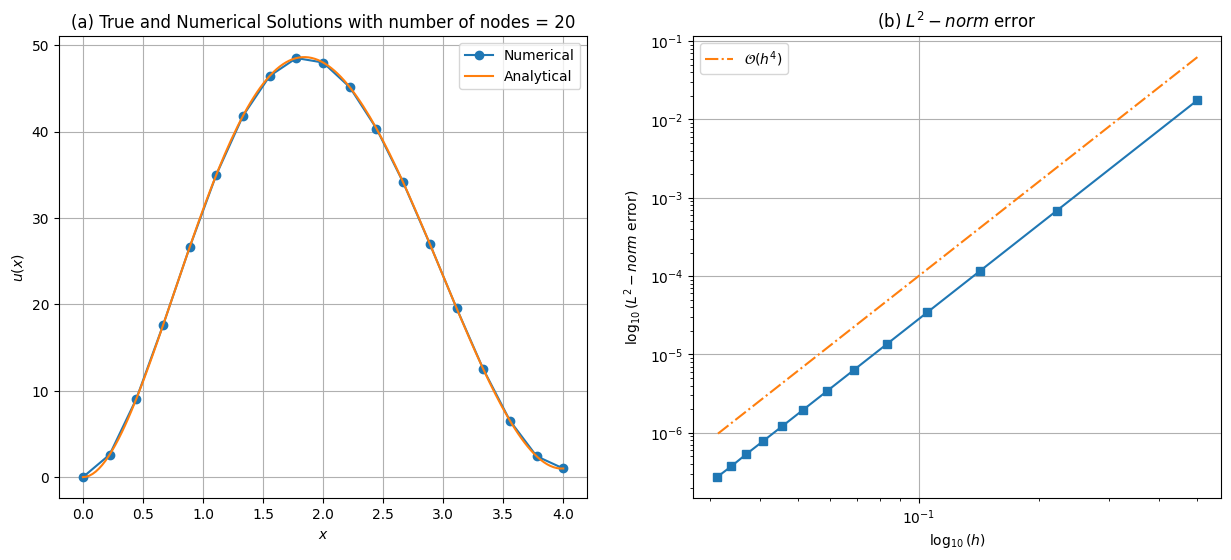

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
####################################################################################################################################################
# axes[0] - Plot of numerical solutions
axes[0].plot(nodes_4, uh_4, "-o", label="Numerical")
axes[0].plot(x_4, [u_4(_) for _ in x_4], label="Analytical")

axes[0].legend(loc="best")
axes[0].grid()
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$u(x)$")
axes[0].set_title(r"(a) True and Numerical Solutions with number of nodes = 20")

####################################################################################################################################################
# axes[1] - l2
axes[1].loglog(h_dist, L2_error_dist, "-s")
axes[1].loglog(
    h_dist,
    [h_dist[i] ** 4 for i in range(len(num_of_nodes_dist))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^4)$",
)
axes[1].legend(loc="best")
axes[1].grid()
axes[1].set_xlabel(r"$\log_{10}(h)$")
axes[1].set_ylabel(r"$\log_{10}(L^2-norm \ \text{error})$")
axes[1].set_title(r"(b) $L^2-norm\ \text{error}$")

* $E(x)$ is continuous 


Solve $$(x u^{\prime \prime})^{\prime \prime} = 0 = f(x)$$ with the boundary conditions being $$u(1) = b_1 = 0 , u^{\prime}(1) = b_2 = 1, u(2) = b_3 = 0, u^{\prime}(2) = b_4 = 1$$ over $\Omega = (1, 2)$

The exact solution is $$u(x) = \frac{(x^2 + x - 2)\log(2) - 2x\log(x)}{\log(8) - 2} $$

In [29]:
u_3_x = lambda x: (x * np.log(4) - 2 * np.log(x) - 2 + np.log(2)) / (np.log(8) - 2)

u_3_xx = lambda x: (2 * np.log(2) - 2 / x) / (np.log(8) - 2)

num_of_nodes_x = np.arange(30, 180, 15)

L2_error_x, H1_semierror_x, H2_semierror_x = [], [], []

bd = [1, 2]

for i in tqdm(num_of_nodes_x):
    error_ = error_L2(u_3, i, E_3, f_3, bcs_3, bd, type="general")
    L2_error_x.append(error_)

    error__ = error_H1_semi_norm(u_3_x, i, E_3, f_3, bcs_3, bd, type="general")
    H1_semierror_x.append(error__)

    error___ = error_H2_semi_norm(u_3_xx, i, E_3, f_3, bcs_3, bd, type="general")
    H2_semierror_x.append(error___)

h_x = [(bd[1] - bd[0]) / (num_of_nodes_x[i] - 1) for i in range(len(num_of_nodes_x))]

100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


In [30]:
H1_error_x = []
H2_error_x = []
for i in range(len(num_of_nodes_x)):
    H1_error_x.append((L2_error_x[i] ** 2 + H1_semierror_x[i] ** 2) ** (1 / 2))
    H2_error_x.append(
        (L2_error_x[i] ** 2 + H1_semierror_x[i] ** 2 + H2_semierror_x[i] ** 2)
        ** (1 / 2)
    )

Text(0.5, 1.0, '(d) $H^2-norm \\ \\text{error}$')

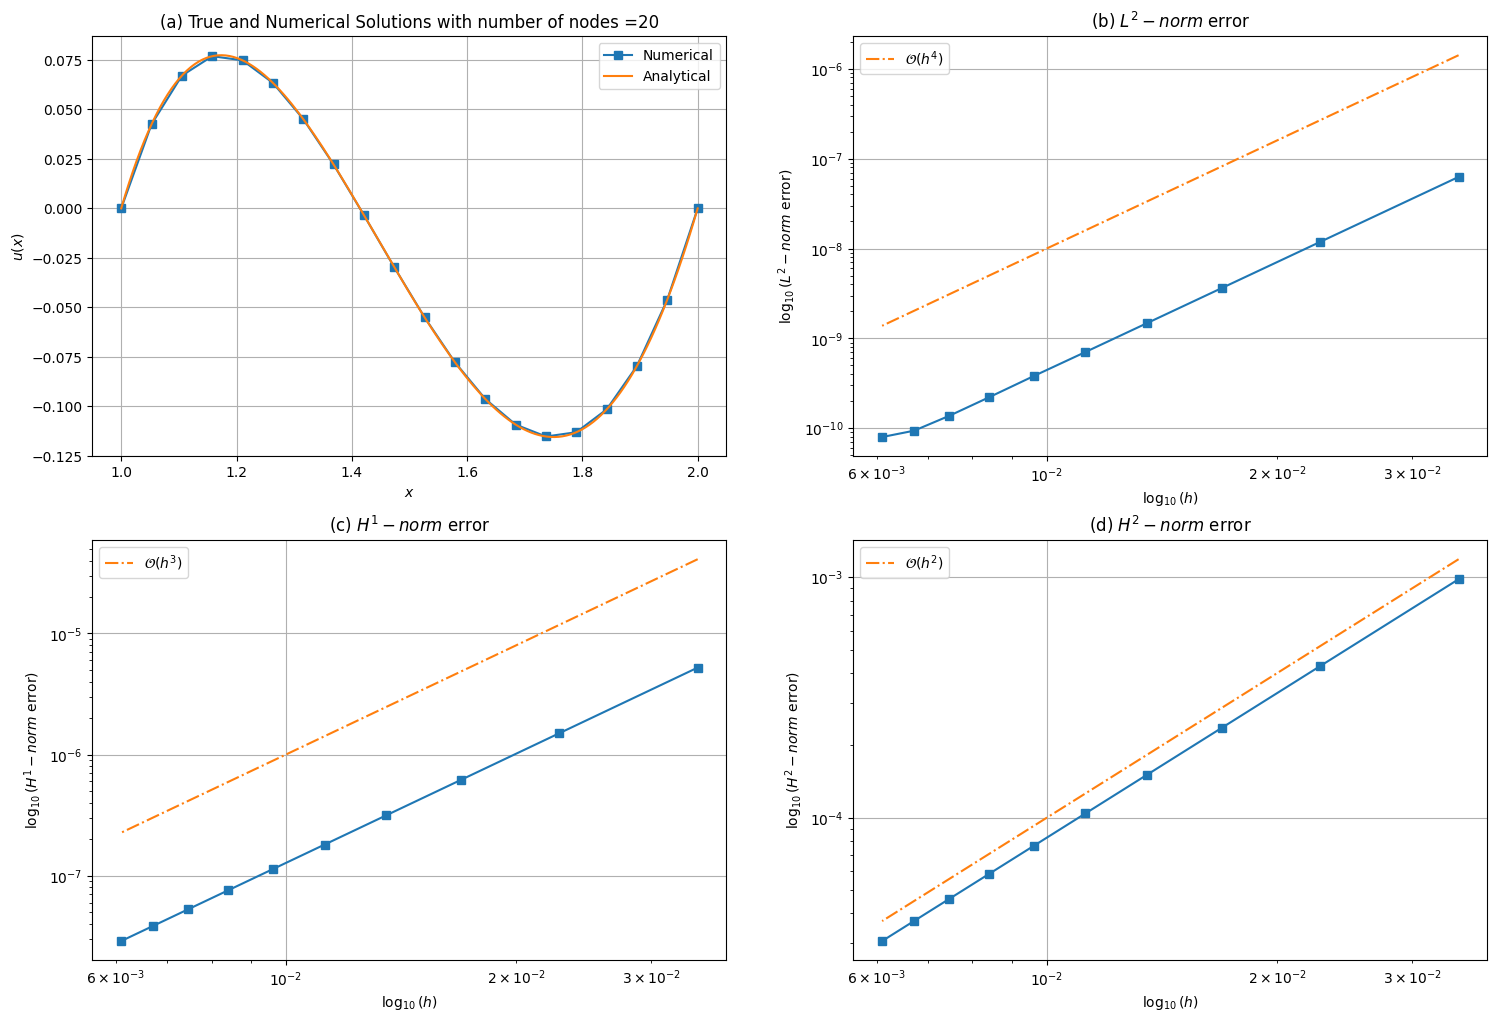

In [31]:
figs, axes = plt.subplots(2, 2, figsize=(18, 12))
####################################################################################################################################################
# axes[0,0] - Plot of numerical solutions
axes[0, 0].plot(nodes_3, uh_3, "-s", label="Numerical")
axes[0, 0].plot(x_3, u_3(x_3), label="Analytical")


axes[0, 0].legend(loc="best")
axes[0, 0].grid()
axes[0, 0].set_xlabel(r"$x$")
axes[0, 0].set_ylabel(r"$u(x)$")
axes[0, 0].set_title(r"(a) True and Numerical Solutions with number of nodes =20")

####################################################################################################################################################
# axes[0,1] - l2
axes[0, 1].loglog(h_x, L2_error_x, "-s")
axes[0, 1].loglog(
    h_x,
    [h_x[i] ** 4 for i in range(len(num_of_nodes_x))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^4)$",
)
axes[0, 1].legend(loc="best")
axes[0, 1].grid()
axes[0, 1].set_xlabel(r"$\log_{10}(h)$")
axes[0, 1].set_ylabel(r"$\log_{10}(L^2-norm \ \text{error})$")
axes[0, 1].set_title(r"(b) $L^2-norm\ \text{error}$")

####################################################################################################################################################
# axes[1,0] - H1
axes[1, 0].loglog(h_x, H1_error_x, "-s")
axes[1, 0].loglog(
    h_x,
    [h_x[i] ** 3 for i in range(len(num_of_nodes_x))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^3)$",
)

axes[1, 0].legend(loc="best")
axes[1, 0].grid()
axes[1, 0].set_xlabel(r"$\log_{10}(h)$")
axes[1, 0].set_ylabel(r"$\log_{10}(H^1-norm \ \text{error})$")
axes[1, 0].set_title(r"(c) $H^1-norm \ \text{error}$")

# # ####################################################################################################################################################
# axes[1,1] - H2
axes[1, 1].loglog(h_x, H2_error_x, "-s")
axes[1, 1].loglog(
    h_x,
    [h_x[i] ** 2 for i in range(len(num_of_nodes_x))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^{2})$",
)

axes[1, 1].legend(loc="best")
axes[1, 1].grid()
axes[1, 1].set_xlabel(r"$\log_{10}(h)$")
axes[1, 1].set_ylabel(r"$\log_{10}(H^2 - norm \ \text{error})$")
axes[1, 1].set_title(r"(d) $H^2-norm \ \text{error}$")

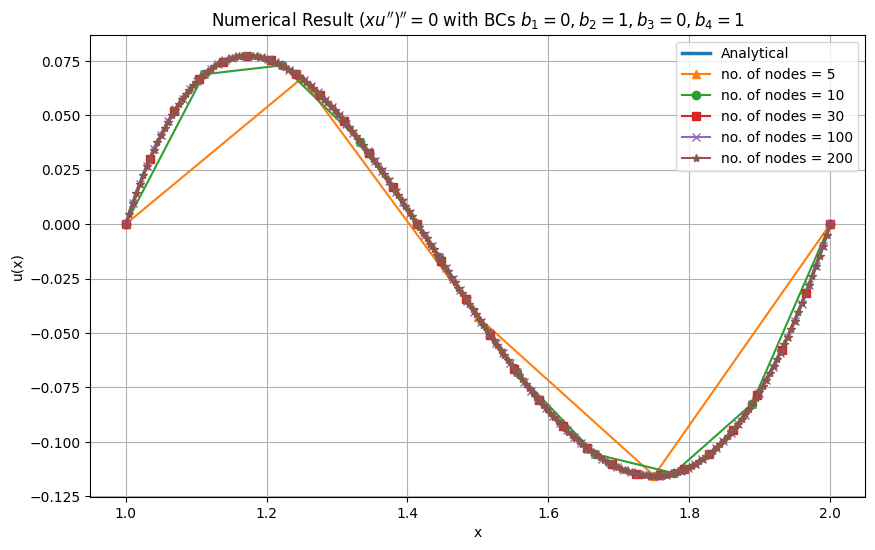

In [32]:
_, ax = plt.subplots(figsize=(10, 6))
marker_ = ["-^", "-o", "-s", "-x", "-*"]
ax.plot(x_3, u_3(x_3), linewidth=2.5, zorder=-1, label="Analytical")
for i, n_ in enumerate([5, 10, 30, 100, 200]):
    uh_, nodes_ = Hermite_solver(
        a=1,
        b=2,
        num_of_nodes=[n_],
        E=E_3,
        f=f_3,
        bcs=bcs_3,
        disctn=None,
        type="general",
    )
    ax.plot(nodes_, uh_, marker_[i], label=f"no. of nodes = {n_}")
ax.legend(loc="best")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.set_title(
    r"Numerical Result $(xu^{\prime \prime})^{\prime \prime} = 0 $ with BCs $b_1 = 0, b_2 = 1, b_3 = 0, b_4 = 1$"
)
ax.grid()

* Both $E(x)$ and $f(x)$ are discontinuous
Consider $$(E(x)u^{\prime \prime})^{\prime \prime} = \mathcal{f}(x) = \begin{cases} 61\sin^2(x)\cos(x) - 20\cos^3(x) & \ \text{if} \ 0 \leq x < 10 \\ \sin(\log(x)) & \ \text{if} \ 10 \leq x \leq 15 \end{cases}$$ with the Boundary Conditions being $$u(0) = b_1 =0 , u^{\prime}(0) = b_2 = 0, u(15) = b_3 = 0, u^{\prime}(15) = b_4 = 0$$ over $\Omega = (0, 15)$ with $$E(x) = \begin{cases} (x + 1)^2 & \ \text{if} \ 0 \leq x < 10 \\ \sin^2(x) + \pi& \ \text{if} \ 10 \leq x \leq 15 \end{cases}$$ now.

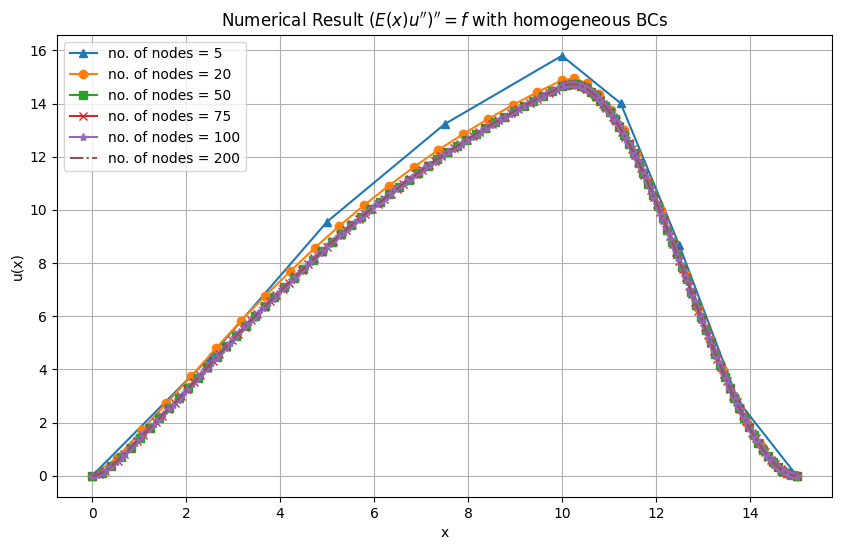

In [33]:
def f_disctnEf(x):
    if 0 <= x < 10:
        return 61 * np.sin(x) ** 2 * np.cos(x) - 20 * np.cos(x) ** 3
    else:
        return np.sin(np.log(x))


def E_disctnEf(x):
    if 0 <= x < 10:
        return (x + 1) ** 2
    else:
        return np.sin(x) ** 2 + np.pi


bcs_disctnEF = [0, 0, 0, 0]


_, axdisctn = plt.subplots(figsize=(10, 6))
marker_ = ["-^", "-o", "-s", "-x", "-*", "-."]
for i, n_ in enumerate([5, 20, 50, 75, 100, 200]):
    uh_, nodes_ = Hermite_solver(
        a=0,
        b=15,
        num_of_nodes=[n_, n_],
        E=E_disctnEf,
        f=f_disctnEf,
        bcs=bcs_disctnEF,
        disctn=[10],
        type="general",
    )
    axdisctn.plot(nodes_, uh_, marker_[i], label=f"no. of nodes = {n_}")
axdisctn.legend(loc="best")
axdisctn.set_xlabel("x")
axdisctn.set_ylabel("u(x)")
axdisctn.set_title(
    r"Numerical Result $(E(x)u^{\prime \prime})^{\prime \prime} = f $ with homogeneous BCs"
)
axdisctn.grid()

### Stability
In this final section, the condition number of the stiffness matrix $A$ will be examined. 

For biharmonic equations, it is suggested that $$\text{cond}(A) = \mathcal{O}(h^{-4})$$

It is expected that as $h$ gets smaller, $\text{cond}(A)$ is huge, indicating a severe instability.

In [ ]:
def cond_A(
    num_of_nodes: int, E, f, bcs: list, bound: list, type="special", disctn=None
):
    # set up the Hermite solver
    if disctn == None:
        nodes = np.linspace(bound[0], bound[1], num_of_nodes)
    else:
        points = [bound[0]] + [disctn] + [bound[1]]
        nodes = np.linspace(points[0], points[1], num_of_nodes)
        for i in range(1, len(points) - 1, 1):
            nodes = np.concatenate(
                (nodes, np.linspace(points[i], points[i + 1], num_of_nodes))
            )
        nodes = np.unique(nodes)

    HS = Hermite_solver_ground(nodes=nodes, E=E, f=f, BCs=bcs)
    A = getattr(HS, f"stiffness_matrix_{type}")()
    return np.linalg.cond(A)

In [ ]:
nodes_cond = [80, 100, 200, 300, 500, 800, 900, 1000, 1200, 1500]

h = [[] for _ in range(4)]

for iter in range(4):
    h_ = [
        (bounds[iter][1] - bounds[iter][0]) / (nodes_cond[i] - 1)
        for i in range(len(nodes_cond))
    ]
    h[iter] = h_

A = [[] for _ in range(4)]

for iter in range(4):
    for n_ in nodes_cond:
        A[iter].append(cond_A(n_, E, fs[iter], bcs[iter], bounds[iter]))

Text(0.5, 1.0, 'Condition Number of Stiffness Global Matrix A (stable)')

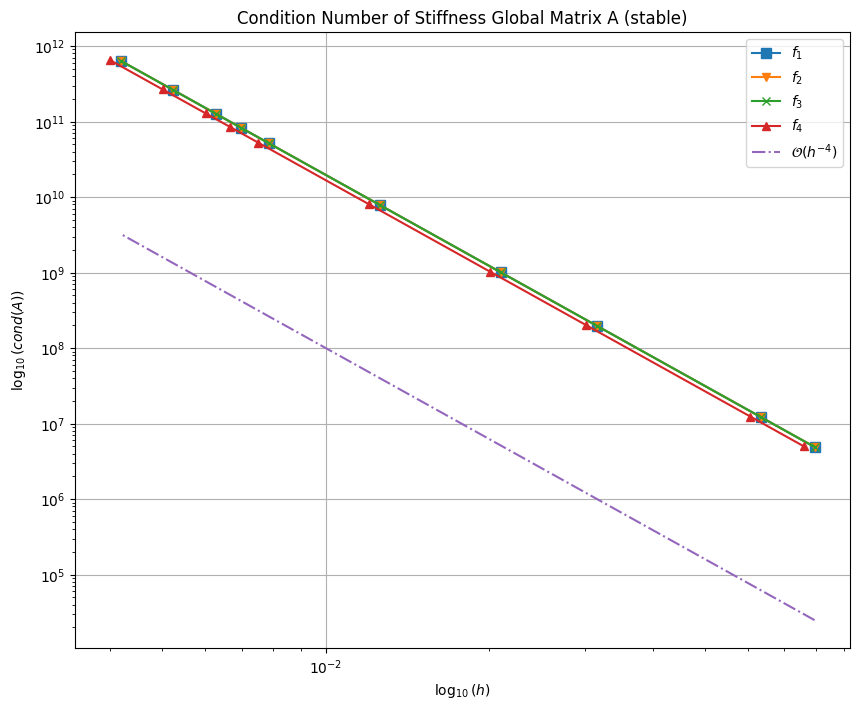

In [ ]:
_, axe = plt.subplots(figsize=(10, 8))
for iter in range(4):
    if iter == 0:
        axe.loglog(h[iter], A[iter], "-s", label=rf"$f_{iter + 1}$", markersize=7)
    else:
        axe.loglog(h[iter], A[iter], marker[iter], label=rf"$f_{iter + 1}$")
axe.loglog(
    h[0],
    [h[0][i] ** (-4) for i in range(len(nodes_cond))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^{-4})$",
)
axe.legend(loc="best")
axe.grid()
axe.set_xlabel(r"$\log_{10}(h)$")
axe.set_ylabel(r"$\log_{10}(cond(A))$")
axe.set_title("Condition Number of Stiffness Global Matrix A (stable)")

* **Instability Visualization - The assumptions of $E(x)$ are violated**:

Solve:$$(\sin(x)u^{\prime \prime})^{\prime \prime} = \mathcal{f}(x) = 82\sin^3(x)\cos(x) - 62\sin(x)\cos^3(x)$$ with the Boundary Conditions being $$u(-2\pi) = b_1 = 0 , u^{\prime}(-2\pi) = b_2 = 0, u(2\pi) = b_3 = 0, u^{\prime}(2\pi) = b_4 = 0$$ over $\Omega = (-2\pi, 2\pi)$ with $E(x) = \sin(x)$.

The exact solution $u(x)$ is $$u(x) = \sin^2(x)\cos(x)$$

In [ ]:
E_5 = lambda x: np.sin(x)
u_5 = lambda x: np.sin(x) ** 2 * np.cos(x)
f_5 = lambda x: 82 * np.sin(x) ** 3 * np.cos(x) - 62 * np.sin(x) * np.cos(x) ** 3
bcs_5 = [0, 0, 0, 0]

uh_5, nodes_5 = Hermite_solver(
    a=-2 * np.pi,
    b=2 * np.pi,
    num_of_nodes=[500],
    E=E_5,
    f=f_5,
    bcs=bcs_5,
    disctn=None,
    type="general",
)
x_5 = np.linspace(-2 * np.pi, 2 * np.pi, 150)

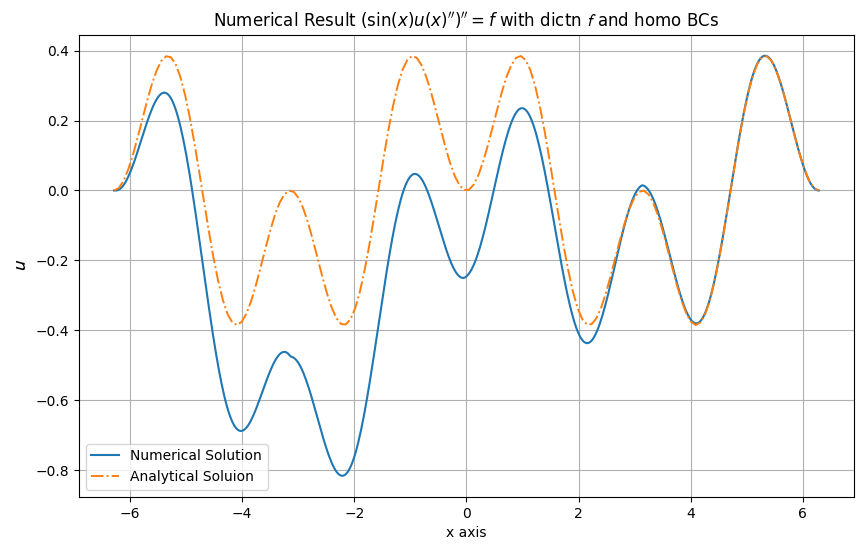

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(nodes_5, uh_5, label="Numerical Solution")
plt.plot(x_5, u_5(x_5), linestyle="dashdot", linewidth=1.4, label="Analytical Soluion")
plt.xlabel("x axis", fontsize=10)
plt.ylabel(r"$\mathcal{u}$", fontsize=15)
plt.title(
    r"Numerical Result $(\sin(x)u(x)^{\prime \prime})^{\prime \prime} = f $ with dictn $\mathcal{f}$ and homo BCs"
)
plt.legend(loc="best")
plt.grid()

In [ ]:
A_ins = []
n_ins = [
    100,
    300,
    500,
    800,
    1000,
    1200,
    1400,
    1500,
    1600,
    1800,
    2000,
    2300,
    2500,
    2700,
    3000,
]

for n_ in n_ins:
    A_ins.append(cond_A(n_, E_5, f_5, bcs_5, [-2 * np.pi, 2 * np.pi], type="general"))

In [ ]:
h_ins = []
for i in range(len(n_ins)):
    h_ins.append(0.25 * np.pi / (n_ins[i] - 1))

Text(0.5, 1.0, 'Condition Number of Stiffness Global Matrix A (instable)')

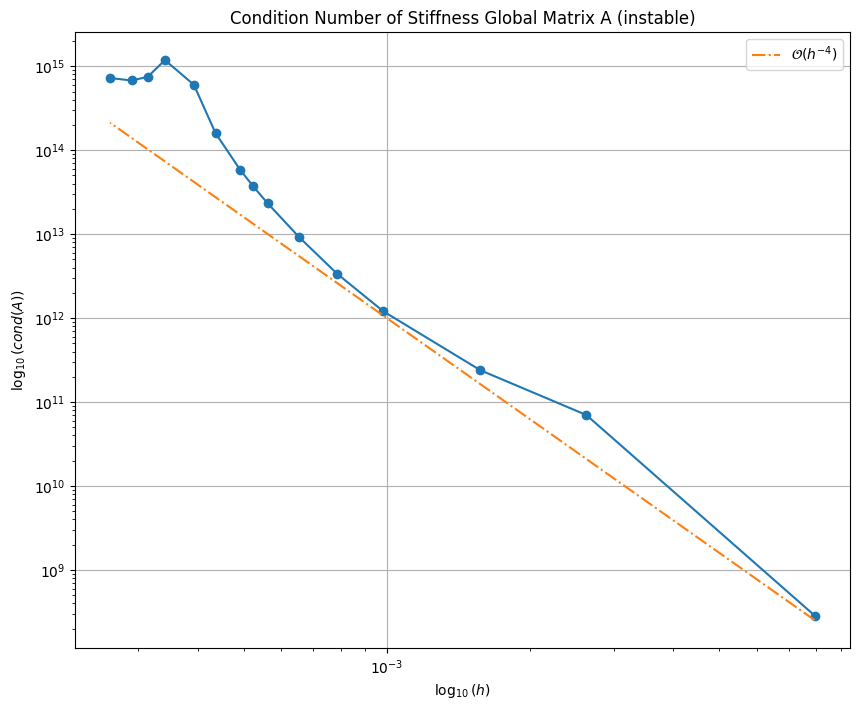

In [ ]:
_, axe = plt.subplots(figsize=(10, 8))
axe.loglog(h_ins, A_ins, "-o")
axe.loglog(
    h_ins,
    [h_ins[i] ** (-4) for i in range(len(n_ins))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^{-4})$",
)
axe.legend(loc="best")
axe.grid()
axe.set_xlabel(r"$\log_{10}(h)$")
axe.set_ylabel(r"$\log_{10}(cond(A))$")
axe.set_title("Condition Number of Stiffness Global Matrix A (instable)")

* Stability - Discontinuous Forcing Term

Consider $$u^{\prime \prime \prime \prime} = \mathcal{f}(x) = \begin{cases} 24 & \ \text{if} \ 0 \leq x < 2 \\ -24 & \ \text{if} \ 2 \leq x \leq 4 \end{cases}$$ with the Boundary Conditions being $$u(0) = b_1 =0 , u^{\prime}(0) = b_2 = 0, u(4) = b_3 = 96, u^{\prime}(4) = b_4 = 12$$ over $\Omega = (0, 5)$ with $E(x) = 1$ now. This is equivalent to the **Discontinous $\mathcal{f}(x)$**.


The exact solution is $$u(x) = \begin{cases} x^4 - 7.25x^3 + 21x^2 & \ \text{if} \ 0 \leq x < 2 \\ -(x-4)^4 - 7.25(x-4)^3 - 18(x-4)^2 + 12(x-4) + 96 & \ \text{if} \ 2 \leq x \leq 4 \end{cases}$$

Text(0.5, 1.0, 'Condition Number of Stiffness Global Matrix A With A Discontinuous f')

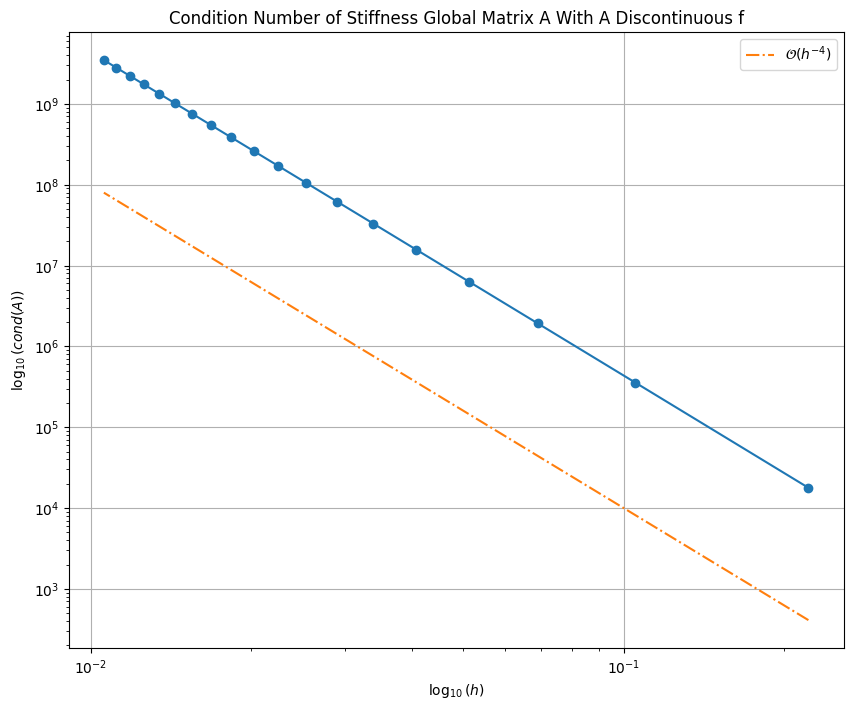

In [ ]:
A_dis = []

for n_ in num_of_nodes_dist:
    A_dis.append(cond_A(n_, E_4, f_4, bcs_4, [0, 4], type="special", disctn=[2]))

_, axe = plt.subplots(figsize=(10, 8))
axe.loglog(h_dist, A_dis, "-o")
axe.loglog(
    h_dist,
    [h_dist[i] ** (-4) for i in range(len(num_of_nodes_dist))],
    linestyle="dashdot",
    label=r"$\mathcal{O}(h^{-4})$",
)
axe.legend(loc="best")
axe.grid()
axe.set_xlabel(r"$\log_{10}(h)$")
axe.set_ylabel(r"$\log_{10}(cond(A))$")
axe.set_title("Condition Number of Stiffness Global Matrix A With A Discontinuous f")